In [1]:
import pandas as pd

# create dummies for Gender and countries 

In [35]:
df15 = pd.read_csv('data/marathon_results_2015.csv')
df16 = pd.read_csv('data/marathon_results_2016.csv')
df17 = pd.read_csv('data/marathon_results_2017.csv')
df18 = pd.read_csv('data/marathon_results_2018.csv')
df18.rename(columns={'Blank': 'Unnamed'}, inplace = True)
print(df18.shape)
df18.head()

(24087, 26)


,Unnamed: 0,Unnamed: 0.1,Bib,Name,Age,M/F,City,State,Country,Citizen,...,25K,30K,35K,40K,Pace,Proj. Time,Official Time,Overall,Gender,Division
0,0,0,189,"Ash, Alan",26,M,Atmore,AL,USA,NaN,...,1:31:16,1:50:19,2:09:22,2:28:08,0:05:58,NaN,2:36:04,63,63,59
1,1,1,855,"Goodman, John Mark",38,M,Birmingham,AL,USA,NaN,...,1:34:33,1:53:49,2:13:27,2:33:06,0:06:11,NaN,2:41:52,187,186,173
2,2,2,1049,"Mcclung, Joshua",34,M,Birmingham,AL,USA,NaN,...,1:35:31,1:55:14,2:15:14,2:34:45,0:06:15,NaN,2:43:42,247,246,226
3,3,3,303,"Graham, James",26,M,Birmingham,AL,USA,NaN,...,1:33:09,1:52:29,2:13:49,2:37:17,0:06:23,NaN,2:47:07,385,377,346
4,4,4,5267,"Pierce, Nathaniel",31,M,Huntsville,AL,USA,NaN,...,1:40:23,2:00:42,2:21:22,2:41:26,0:06:30,NaN,2:50:19,608,593,536


In [36]:
import numpy as np

def clean_bib(bib):
    '''Strip the bib number and make an int'''
    return int(bib.strip('F'))

def seconds_converter(time):
    '''Takes a time in the string form '00:00:00' and converts it into integer 
    of seconds.  Handles special '-' cases and converts them to NaN '''
    
    if time == '-':
        return np.nan
    
    time_split = [int(x) for x in(time.split(':'))]
    return time_split[0]*(60**2) + time_split[1]*60 + time_split[2] 

def best_fit_slope(x,y):
    '''Calculate the best fit slope for all 5K splits.'''
    m = (((x.mean()*y.mean()) - (x*y).mean()) / 
         (x.mean()**2 - (x**2).mean()))
    return round(m, 2)


def race_slope(row):
    '''Create a new column of the race progression slope.'''
    nK_splits = ['5K', '10K', '15K', '20K', 'Half', '25K', '30K', '35K', '40K']
    x = np.array([5, 10, 15, 20, 21.1, 25, 30, 35, 40])
    y = np.array([row['5K']] + list(np.diff(row[nK_splits])))
    
    return best_fit_slope(x,y)

def add_weather_data(df, year):
    '''Add the weather data for the corresponding year.'''
    
    year = int(year)
    median = df['Official Time'].median()/3600

    pre_median_2015 = {'temp': 48, 'dew_point': 39, 'humidity': 0.71, 'wind': 17, 'gusts': 26}
    post_median_2015 = {'temp': 44, 'dew_point': 41, 'humidity': 0.89,'wind': 16, 'gusts': 0}
    pre_median_2016 = {'temp': 64, 'dew_point': 31, 'humidity': 0.29, 'wind': 14, 'gusts': 22}
    post_median_2016 = {'temp': 53, 'dew_point': 37, 'humidity': 0.55, 'wind': 14, 'gusts': 0}
    pre_median_2017 = {'temp': 74, 'dew_point': 40, 'humidity': 0.29, 'wind': 21, 'gusts': 29}
    post_median_2017 = {'temp': 73, 'dew_point': 34, 'humidity': 0.24, 'wind': 22, 'gusts': 28}
    pre_median_2018 = {'temp': 45, 'dew_point': 43, 'humidity': 0.93, 'wind': 14, 'gusts': 23}
    post_median_2018 = {'temp': 44, 'dew_point': 44, 'humidity': 1.00, 'wind': 17, 'gusts': 0}
    
    new_cols = ['temp', 'dew_point', 'humidity', 'wind', 'gusts']
    
    for col in new_cols:
        if year == 2015:
            df[col] = [pre_median_2015[col] if x < median else post_median_2015[col] for x in df['Official Time']]
        elif year == 2016:
            df[col] = [pre_median_2016[col] if x < median else post_median_2016[col] for x in df['Official Time']]
        elif year == 2017:
            df[col] = [pre_median_2017[col] if x < median else post_median_2017[col] for x in df['Official Time']]
        else:
            df[col] = [pre_median_2018[col] if x < median else post_median_2018[col] for x in df['Official Time']]

    return df
    

def clean_data(df, year):
    '''Takes in a DataFrame, drops unnecessary columns, and applies seconds_converter. ''' 
    
    # drop duplicates bib as they should be unique
    df.drop_duplicates('Bib', inplace=True)
    
    # clean the bib value convert to int
    df['Bib'] = df['Bib'].apply(clean_bib)
        
    # rename columns for clarity
    df.rename(columns={'Overall': 'overall_rank', 'Gender': 'gender_rank', 
                         'Division': 'division_rank', 'M/F': 'Gender'}, inplace = True)
    
    # convert the time to seconds on these columns
    time_cols = ['5K', '10K', '15K', '20K', 'Half', '25K', 
             '30K', '35K', '40K', 'Official Time']
    for col in time_cols:
        df[col] = df[col].apply(seconds_converter)
        
    # fill the State column with NaNs to 'none' instead so it can be 
    # concatenated with the country column
    df['State'].fillna('', inplace=True)
    df['state_country'] = df['State'] + '_' + df['Country']
    
    # create a new column progression_slope
    df['progression_slope'] = df.apply(race_slope, axis=1) 
    
    # add weather data
    df = add_weather_data(df, year)
    
    # make gender binary
    df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
    
    # drop unnecessary columns
    df.drop(['Citizen', 'City', 'State', 'Country', '5K', '10K', '15K', '20K', 
             '25K', '30K', '35K', '40K', 'Pace', 'Half'], axis=1, inplace=True)
    df.drop(list(df.filter(regex='Unnamed')), axis=1, inplace=True)
    df.drop(list(df.filter(regex='Proj')), axis=1, inplace=True)
 
    return df


In [38]:
df15 = clean_data(df15, 2015)
df16 = clean_data(df16, 2016)
df17 = clean_data(df17, 2017)
df18 = clean_data(df18, 2018)
df18.head()

,Bib,Name,Age,Official Time,overall_rank,division_rank,Gender_2,Gender_3,Gender_4,Gender_5,...,Gender_14201,Gender_14203,state_country,progression_slope,temp,dew_point,humidity,wind,gusts,Gender_M
0,189,"Ash, Alan",26,9364,63,59,0,0,0,0,...,0,0,AL_USA,2.25,44,44,1.0,17,0,1
1,855,"Goodman, John Mark",38,9712,187,173,0,0,0,0,...,0,0,AL_USA,1.95,44,44,1.0,17,0,1
2,1049,"Mcclung, Joshua",34,9822,247,226,0,0,0,0,...,0,0,AL_USA,2.40,44,44,1.0,17,0,1
3,303,"Graham, James",26,10027,385,346,0,0,0,0,...,0,0,AL_USA,7.44,44,44,1.0,17,0,1
4,5267,"Pierce, Nathaniel",31,10219,608,536,0,0,0,0,...,0,0,AL_USA,0.95,44,44,1.0,17,0,1


In [17]:
df18['state_country'].nunique()

163

In [24]:
df18_corr = df18[['Bib', 'Age', 'Official Time', 'overall_rank', 'gender_rank', 
                  'division_rank', 'progression_slope']].corr()
df18_corr

,Bib,Age,Official Time,overall_rank,gender_rank,division_rank,progression_slope
Bib,1.000000,0.360381,0.735057,0.798747,0.645077,0.159752,0.228423
Age,0.360381,1.000000,0.412391,0.455777,0.559613,-0.519634,0.209196
Official Time,0.735057,0.412391,1.000000,0.943952,0.858126,0.261994,0.609179
overall_rank,0.798747,0.455777,0.943952,1.000000,0.893899,0.272326,0.558962
gender_rank,0.645077,0.559613,0.858126,0.893899,1.000000,0.245894,0.585217
division_rank,0.159752,-0.519634,0.261994,0.272326,0.245894,1.000000,0.235788
progression_slope,0.228423,0.209196,0.609179,0.558962,0.585217,0.235788,1.000000


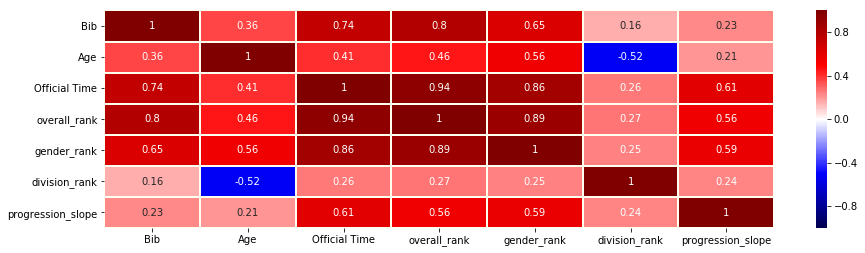

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


fig, ax = plt.subplots(figsize=(15,4))
sns.heatmap(df18_corr, ax=ax, cmap="seismic", annot=True, 
            vmin=-1, vmax=1, linewidths=1, linecolor='ivory');

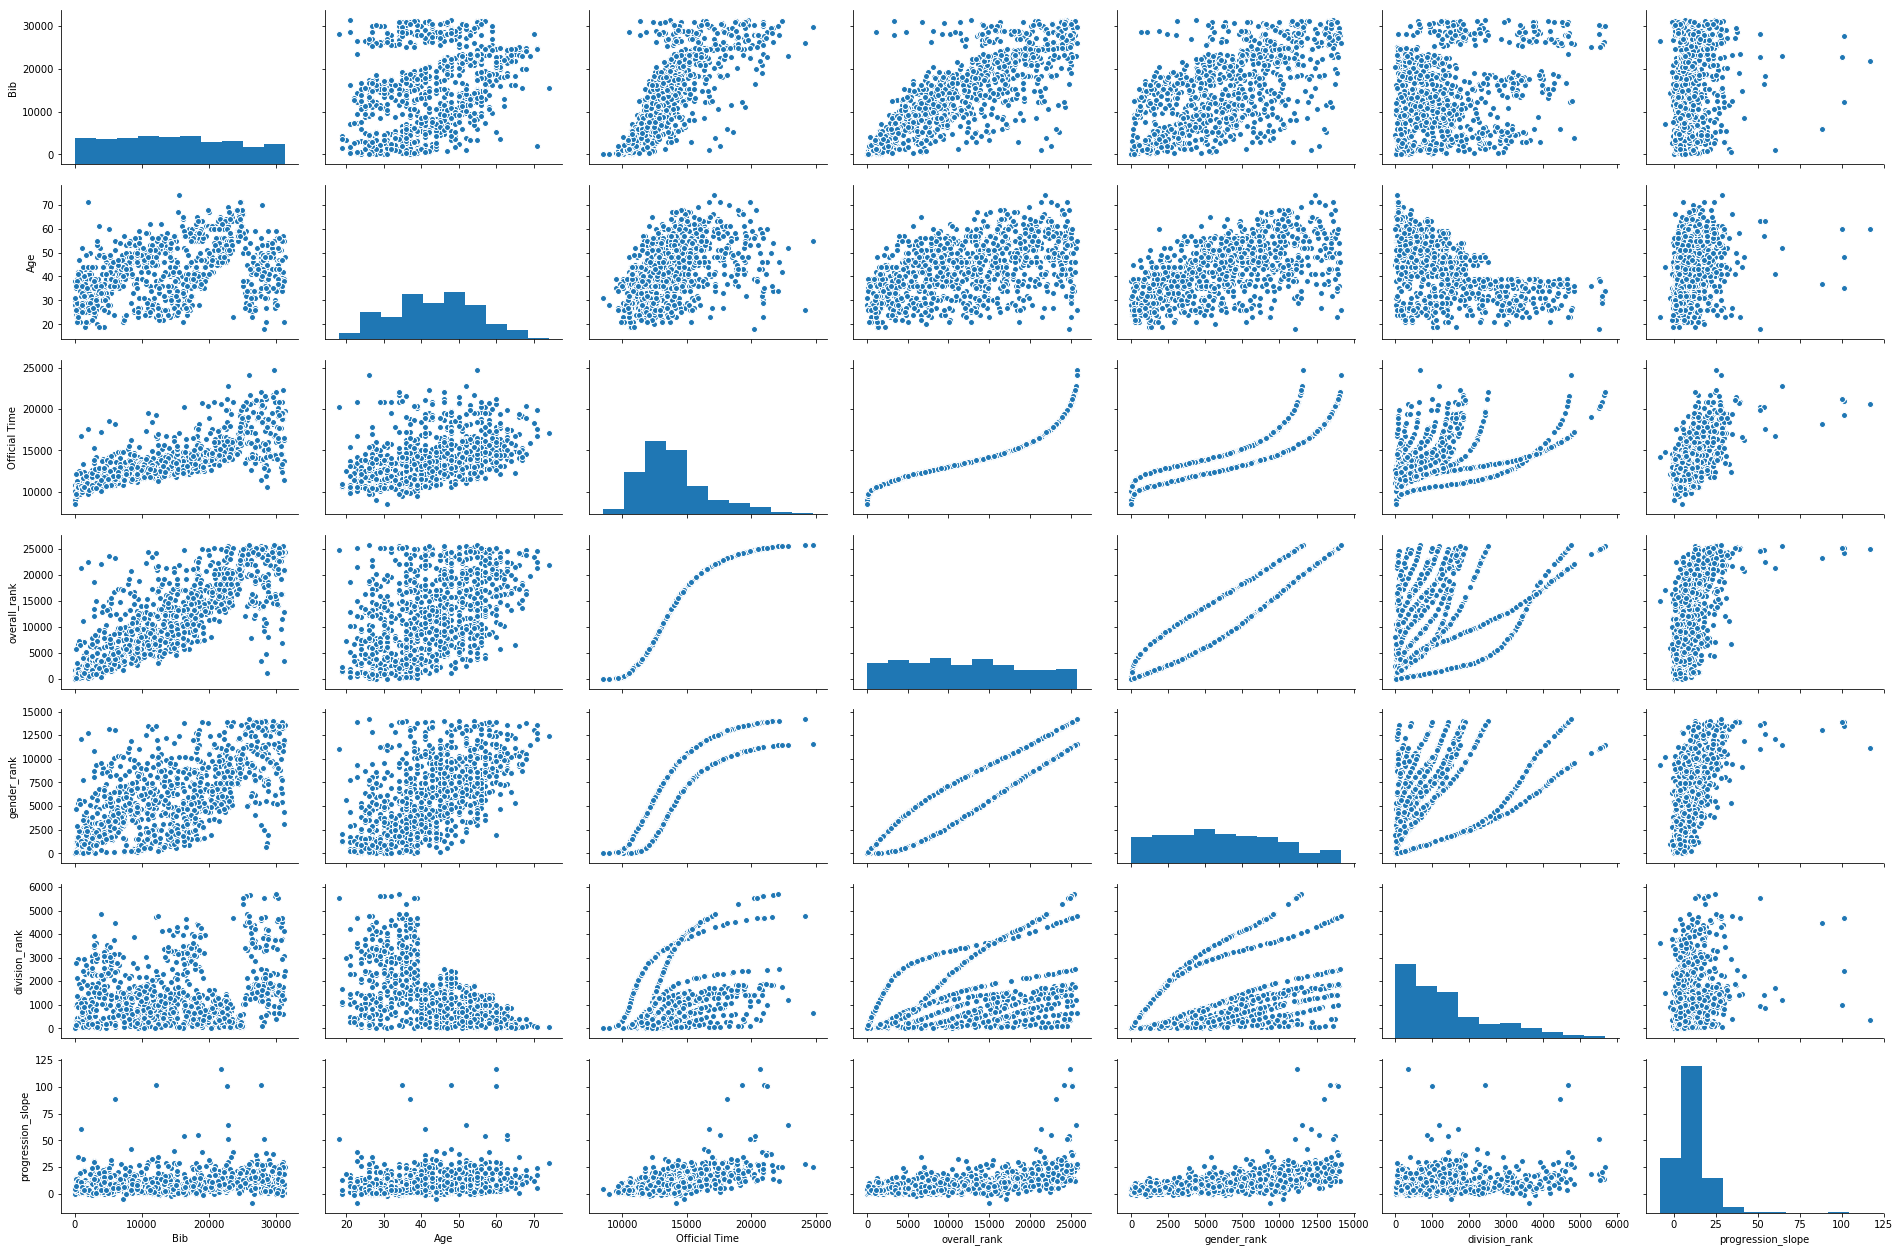

In [28]:
corr_test = df18[['Bib', 'Age', 'Official Time', 'overall_rank', 'gender_rank', 
                  'division_rank', 'progression_slope']].dropna().sample(1000)
sns.pairplot(corr_test, aspect=1.5);

In [29]:
legacy_runners = list(set(df15['Name']).intersection(df16['Name']).intersection(df17['Name']).intersection(df18['Name']))
len(legacy_runners)

1027

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV


In [ ]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df18, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()